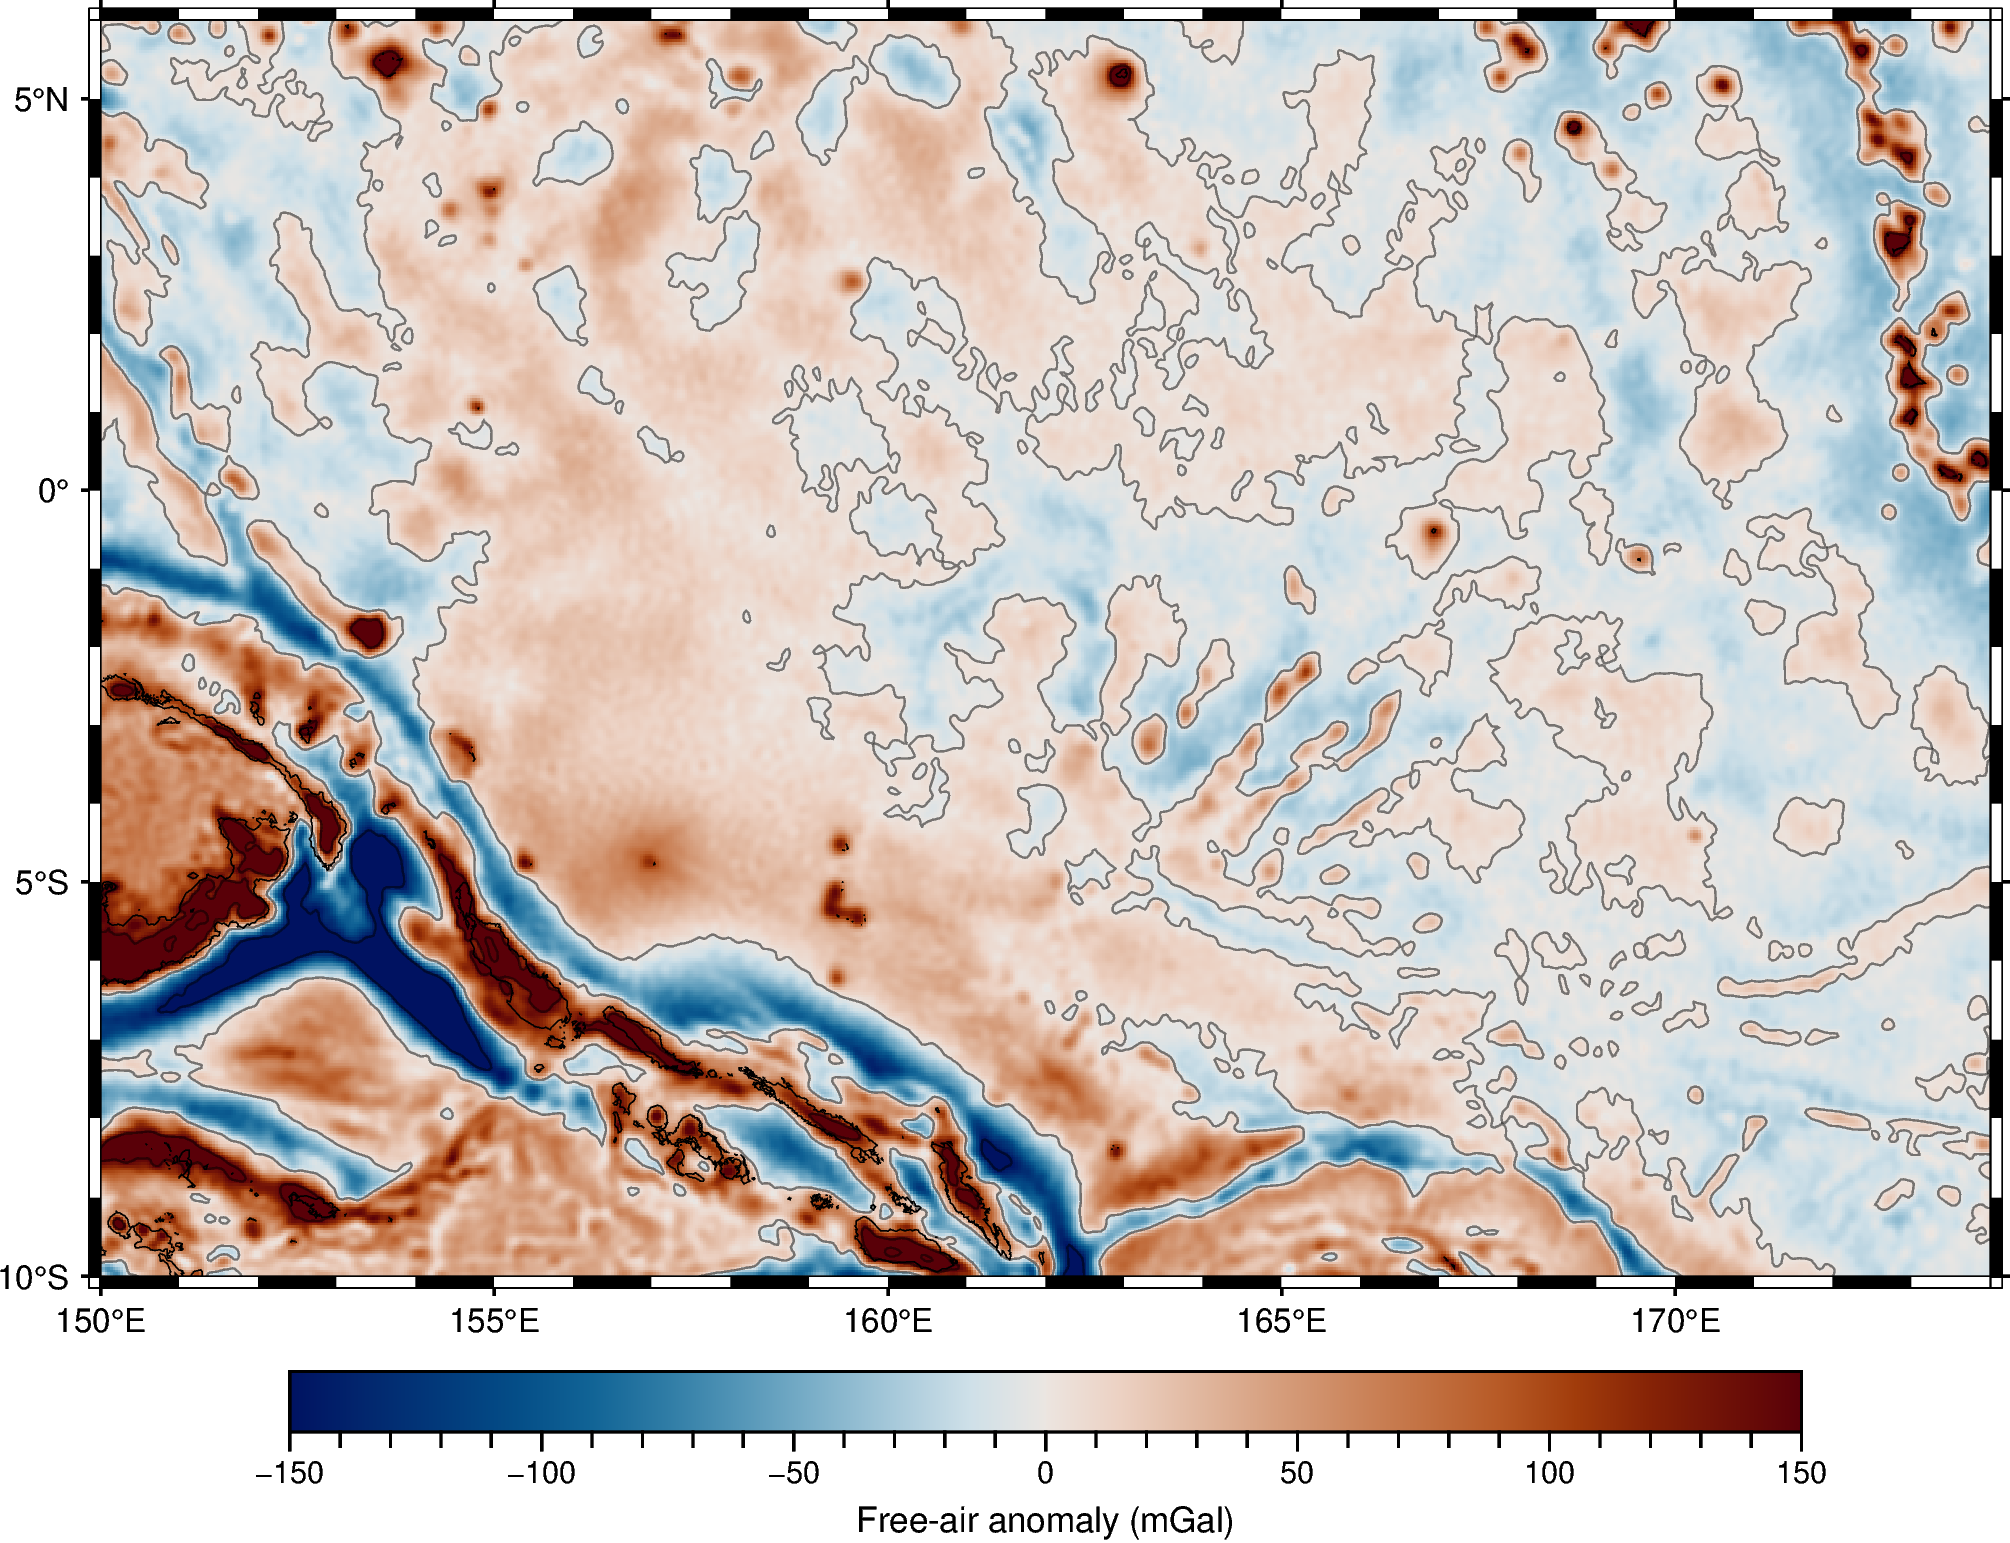

Saved: E:\wjy\Gravity\out\pic\fig2a_WGM_freeair_OJP.png


In [1]:
#第一幅图 自由空气重力异常
import numpy as np
import pandas as pd
import xarray as xr
import pygmt
from pathlib import Path


REGION = [150, 174, -10, 6]  # [lon_min, lon_max, lat_min, lat_max]

DATA_DIR = Path(r"E:\wjy\Gravity\data\WGM2012_java数据\150_174_-10_6")
OUT_DIR  = Path(r"E:\wjy\Gravity\out\pic")
OUT_DIR.mkdir(parents=True, exist_ok=True)


FAA_TXT = DATA_DIR / "grid_freeair_150_174_-10_6.txt"


def read_wgm_xyz_to_da(txt_path: Path) -> xr.DataArray:
    """
    读取 WGM 三列表 (lon, lat, value) 文本为 xarray.DataArray(lat, lon)
    """
    df = pd.read_csv(
        txt_path,
        delim_whitespace=True,
        header=None,
        names=["lon", "lat", "val"],
        comment="#",
    )
    lons = np.sort(df["lon"].unique())
    lats = np.sort(df["lat"].unique())

    Z = (
        df.pivot(index="lat", columns="lon", values="val")
        .reindex(index=lats, columns=lons)
        .values
    )

    da = xr.DataArray(
        Z,
        coords={"lat": lats, "lon": lons},
        dims=("lat", "lon"),
        name="z",
    )
    return da.sortby(["lat", "lon"])


# ---------- 通用绘图函数 ----------
def plot_wgm_map(grid_txt: Path, out_png: Path, cbar_label: str):
    """
    读取给定 WGM 网格并按统一风格绘图
    """
    # 读数据
    da = read_wgm_xyz_to_da(grid_txt)

    # 计算色标范围
    V = float(np.nanpercentile(np.abs(da.values), 98))
    if not np.isfinite(V) or V == 0:
        V = 10.0
    V = np.ceil(V / 10.0) * 10.0  # 四舍五入到 10 mGal

    # GMT 全局样式
    pygmt.config(
        MAP_FRAME_PEN="0.7p,black",
        MAP_TICK_PEN_PRIMARY="0.7p,black",
        FONT_ANNOT_PRIMARY="8p,Helvetica",
        FONT_LABEL="9p,Helvetica",
    )

    # 统一使用 polar 配色
    pygmt.makecpt(
        cmap="SCM/vik",                       # 蓝-白-红
        series=[-V, V, max(V / 10.0, 5)],   # 第三个为色带步长
        continuous=True,
    )

    # ---- 绘图 ----
    fig = pygmt.Figure()

    fig.grdimage(
        grid=da,
        region=REGION,
        projection="M16c",
        cmap=True,
        nan_transparent=True,
    )

    fig.coast(
        shorelines="0.25p,black",
        frame=["WSne", "xaf", "yaf"],
    )

    # 少量等值线（含 0 线），避免旧版 GMT 的 limit=[0,0] bug
    try:
        fig.grdcontour(
            grid=da,
            interval=V,              # 只画 -V, 0, +V 左右几条线
            cut=V / 10.0,
            pen="0.4p,black@50",     # 适当透明
        )
    except Exception as e:
        print(f"grdcontour failed for {out_png.name}, skip contours:", e)

    fig.colorbar(
        frame=[f'af+l"{cbar_label}"'],
    )

    fig.savefig(str(out_png), dpi=400)
    fig.show()
    print("Saved:", out_png)


# ---------- 分别绘制三幅图 ----------
plot_wgm_map(
    grid_txt=FAA_TXT,
    out_png=OUT_DIR / "fig2a_WGM_freeair_OJP.png",
    cbar_label="Free-air anomaly (mGal)",
)


Bouguer stats: min = 132.88 max = 589.41 mean = 427.80058725320873


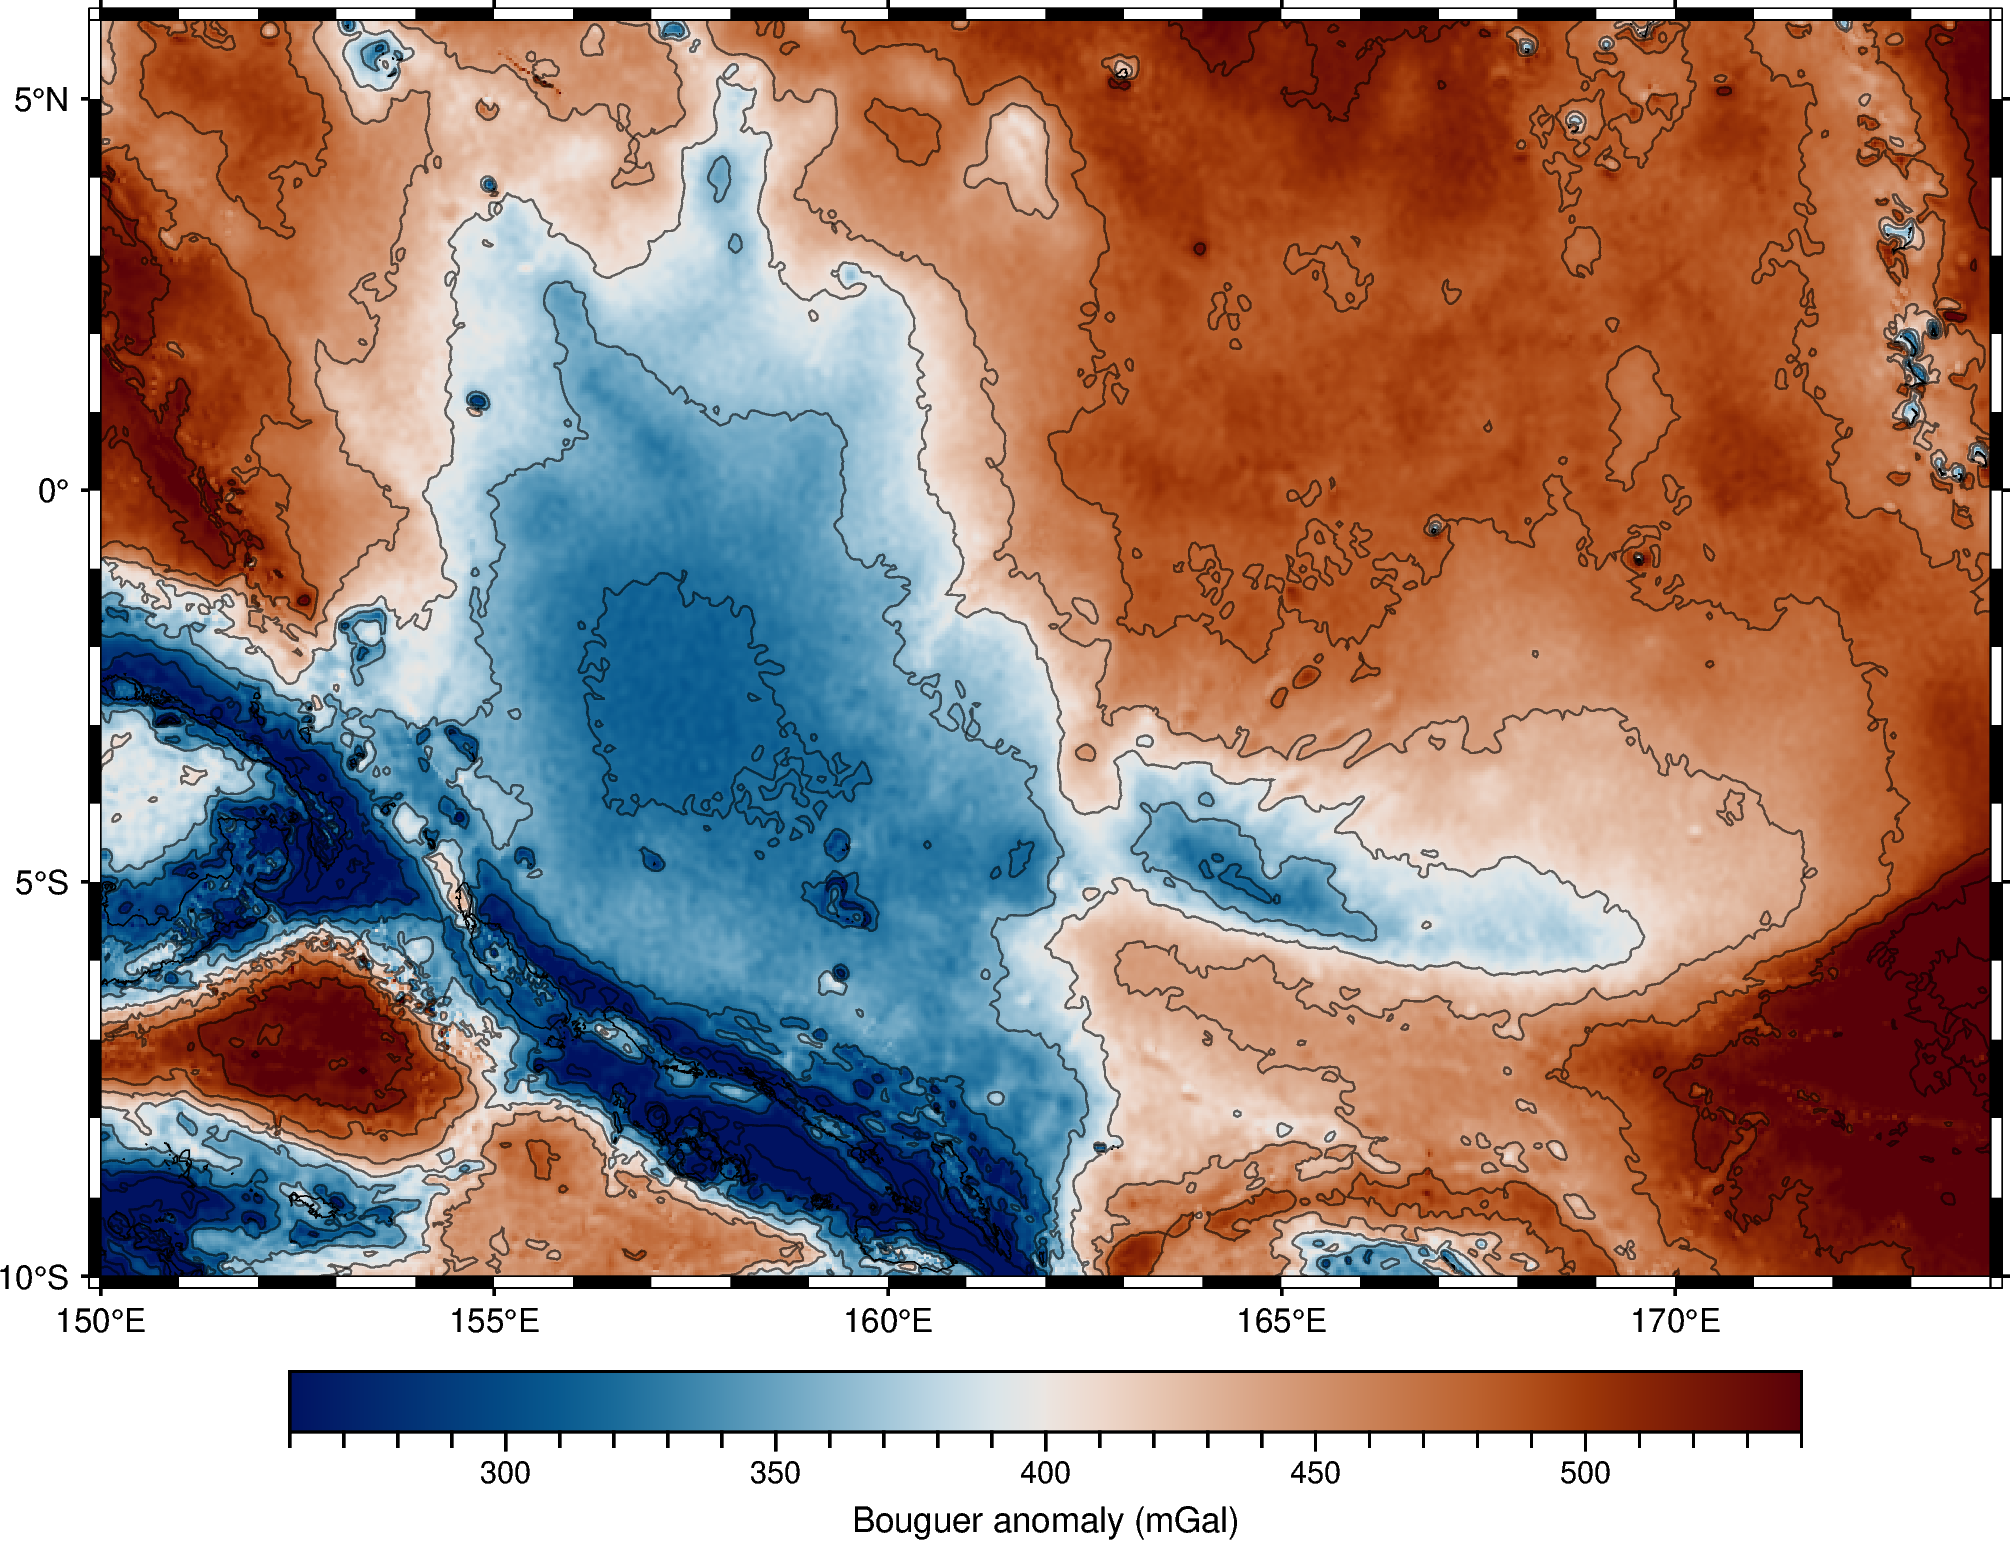

Saved: E:\wjy\Gravity\out\pic\fig2b_WGM_bouguer_OJP.png


In [1]:
# fig2b_wgm_bouguer.py —— OJP 区域 WGM Bouguer 异常（SCM/vik）

import numpy as np
import pandas as pd
import xarray as xr
import pygmt
from pathlib import Path

# ---------- 基本配置 ----------
REGION = [150, 174, -10, 6]  # [lon_min, lon_max, lat_min, lat_max]

# WGM2012 Bouguer 三列表 txt（lon lat value）
WGM_BA_TXT = Path(
    r"E:\wjy\Gravity\data\WGM2012_java数据\150_174_-10_6\grid_bouguer_150_174_-10_6.txt"
)

OUT_FIG = Path(r"E:\wjy\Gravity\out\pic\fig2b_WGM_bouguer_OJP.png")
OUT_FIG.parent.mkdir(parents=True, exist_ok=True)


def read_wgm_xyz_to_da(txt_path: Path) -> xr.DataArray:
    """读取 WGM 三列表 (lon, lat, value) 文本为 xarray.DataArray(lat, lon)"""
    df = pd.read_csv(
        txt_path,
        delim_whitespace=True,
        header=None,
        names=["lon", "lat", "val"],
        comment="#",
    )
    lons = np.sort(df["lon"].unique())
    lats = np.sort(df["lat"].unique())
    Z = (
        df.pivot(index="lat", columns="lon", values="val")
        .reindex(index=lats, columns=lons)
        .values
    )
    da = xr.DataArray(
        Z,
        coords={"lat": lats, "lon": lons},
        dims=("lat", "lon"),
        name="z",
    )
    return da.sortby(["lat", "lon"])


# ---------- 读 Bouguer 数据 ----------
boug = read_wgm_xyz_to_da(WGM_BA_TXT)

# 你可以打印一下统计量确认范围
print(
    "Bouguer stats:",
    "min =", float(np.nanmin(boug.values)),
    "max =", float(np.nanmax(boug.values)),
    "mean =", float(np.nanmean(boug.values)),
)

pygmt.config(
    MAP_FRAME_PEN="0.7p,black",
    MAP_TICK_PEN_PRIMARY="0.7p,black",
    FONT_ANNOT_PRIMARY="8p,Helvetica",
    FONT_LABEL="9p,Helvetica",
)

# ===== 关键：SCM/vik 色标 + 按数据分布设置 series =====
# 这里根据你这份网格的数据分布，采用 [260, 540, 10]
pygmt.makecpt(
    cmap="vik",                 # Scientific Colour Maps 的 vik
    series=[260, 540, 10],      # [min, max, step]，你可以按需要再微调
    continuous=True,
)

# ---------- 绘图 ----------
fig = pygmt.Figure()

fig.grdimage(
    grid=boug,
    region=REGION,
    projection="M16c",
    cmap=True,
    nan_transparent=True,
)

fig.coast(
    shorelines="0.25p,black",
    frame=["WSne", "xaf", "yaf"],
)

# 等值线：适度的间隔，避免太密
try:
    fig.grdcontour(
        grid=boug,
        interval=40,           # 每 20 mGal 一条，既有结构感又不太乱
        cut=10,                 # 去掉很短的小线段
        pen="0.4p,black@40",   # 40% 透明
    )
except Exception as e:
    print("grdcontour failed, skip contours:", e)

fig.colorbar(
    frame=['af+l"Bouguer anomaly (mGal)"'],
)

fig.savefig(str(OUT_FIG), dpi=400)
fig.show()
print("Saved:", OUT_FIG)


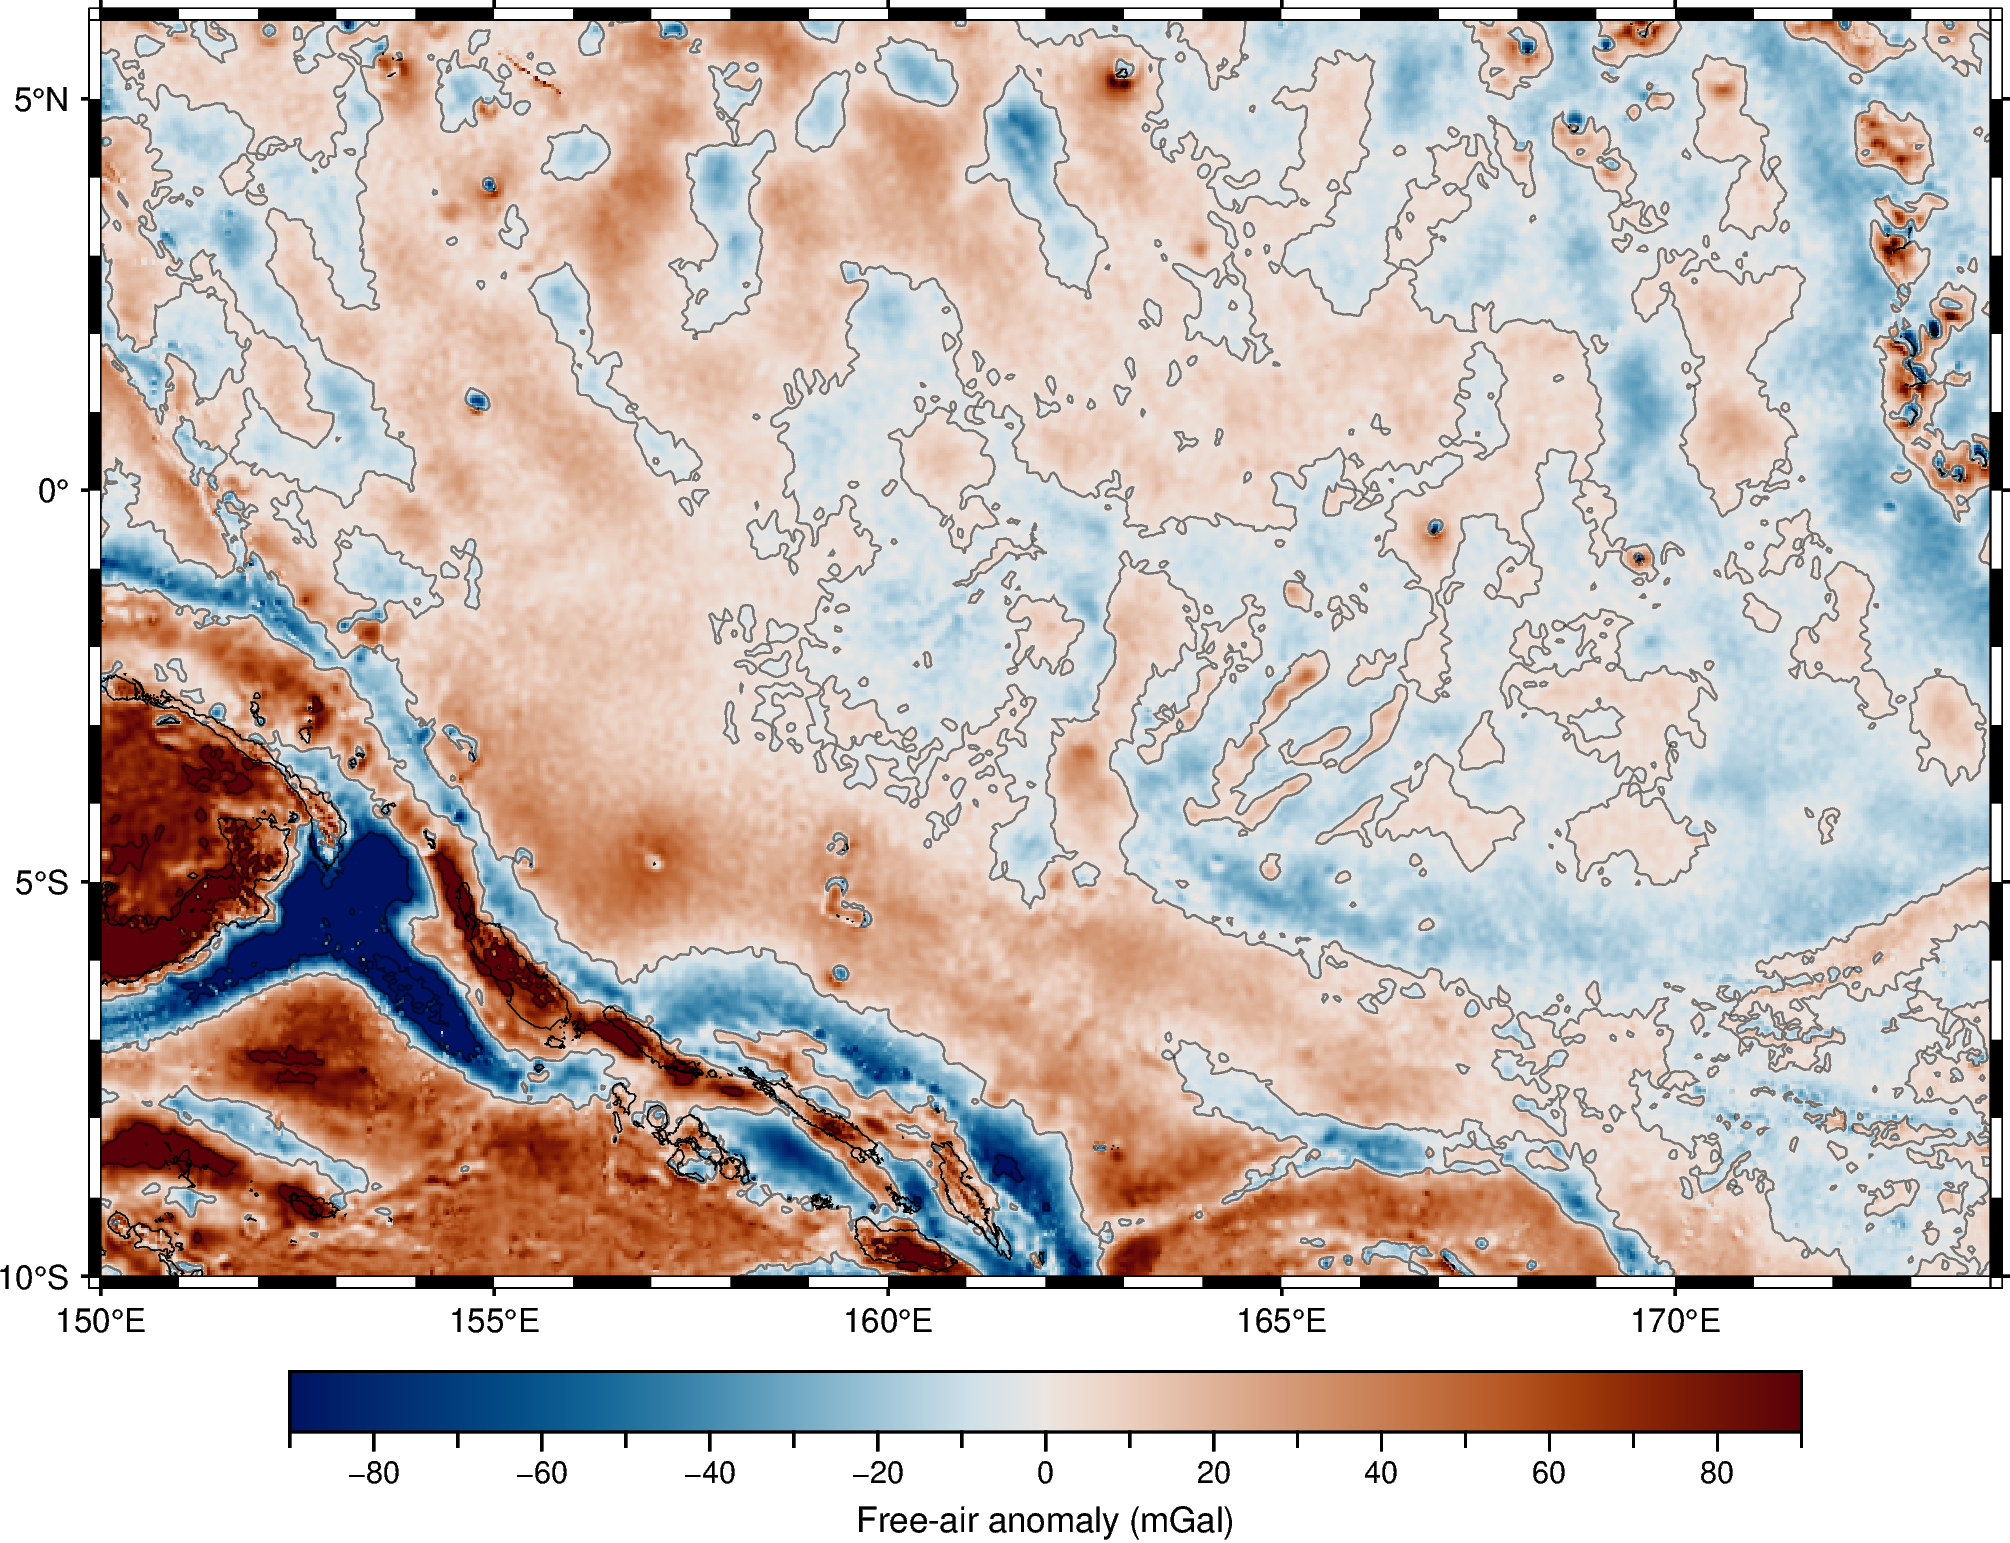

Saved: E:\wjy\Gravity\out\pic\fig2a_WGM_freeair_OJP.png


In [1]:
#第一幅图 自由空气重力异常
import numpy as np
import pandas as pd
import xarray as xr
import pygmt
from pathlib import Path


REGION = [150, 174, -10, 6]  # [lon_min, lon_max, lat_min, lat_max]

DATA_DIR = Path(r"E:\wjy\Gravity\data\WGM2012_java数据\150_174_-10_6")
OUT_DIR  = Path(r"E:\wjy\Gravity\out\pic")
OUT_DIR.mkdir(parents=True, exist_ok=True)


ISO_TXT = DATA_DIR / "grid_isostatic_150_174_-10_6.txt"


def read_wgm_xyz_to_da(txt_path: Path) -> xr.DataArray:
    """
    读取 WGM 三列表 (lon, lat, value) 文本为 xarray.DataArray(lat, lon)
    """
    df = pd.read_csv(
        txt_path,
        delim_whitespace=True,
        header=None,
        names=["lon", "lat", "val"],
        comment="#",
    )
    lons = np.sort(df["lon"].unique())
    lats = np.sort(df["lat"].unique())

    Z = (
        df.pivot(index="lat", columns="lon", values="val")
        .reindex(index=lats, columns=lons)
        .values
    )

    da = xr.DataArray(
        Z,
        coords={"lat": lats, "lon": lons},
        dims=("lat", "lon"),
        name="z",
    )
    return da.sortby(["lat", "lon"])


# ---------- 通用绘图函数 ----------
def plot_wgm_map(grid_txt: Path, out_png: Path, cbar_label: str):
    """
    读取给定 WGM 网格并按统一风格绘图
    """
    # 读数据
    da = read_wgm_xyz_to_da(grid_txt)

    # 计算色标范围
    V = float(np.nanpercentile(np.abs(da.values), 98))
    if not np.isfinite(V) or V == 0:
        V = 10.0
    V = np.ceil(V / 10.0) * 10.0  # 四舍五入到 10 mGal

    # GMT 全局样式
    pygmt.config(
        MAP_FRAME_PEN="0.7p,black",
        MAP_TICK_PEN_PRIMARY="0.7p,black",
        FONT_ANNOT_PRIMARY="8p,Helvetica",
        FONT_LABEL="9p,Helvetica",
    )

    # 统一使用 polar 配色
    pygmt.makecpt(
        cmap="SCM/vik",                       # 蓝-白-红
        series=[-V, V, max(V / 10.0, 5)],   # 第三个为色带步长
        continuous=True,
    )

    # ---- 绘图 ----
    fig = pygmt.Figure()

    fig.grdimage(
        grid=da,
        region=REGION,
        projection="M16c",
        cmap=True,
        nan_transparent=True,
    )

    fig.coast(
        shorelines="0.25p,black",
        frame=["WSne", "xaf", "yaf"],
    )

    # 少量等值线（含 0 线），避免旧版 GMT 的 limit=[0,0] bug
    try:
        fig.grdcontour(
            grid=da,
            interval=V,              # 只画 -V, 0, +V 左右几条线
            cut=V / 10.0,
            pen="0.4p,black@50",     # 适当透明
        )
    except Exception as e:
        print(f"grdcontour failed for {out_png.name}, skip contours:", e)

    fig.colorbar(
        frame=[f'af+l"{cbar_label}"'],
    )

    fig.savefig(str(out_png), dpi=400)
    fig.show()
    print("Saved:", out_png)


# ---------- 分别绘制三幅图 ----------
plot_wgm_map(
    grid_txt=ISO_TXT,
    out_png=OUT_DIR / "fig2a_WGM_freeair_OJP.png",
    cbar_label="Free-air anomaly (mGal)",
)
